In [14]:
import os
os.chdir('..')
import src.models_and_optimizers as model_utils
import yaml
from types import SimpleNamespace
from clip_main import get_wds_loaders
from transformers import EsmTokenizer
import src.data_utils as data_utils
import torch
import sys
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.cuda.amp import autocast
from scipy.stats.stats import pearsonr 
import matplotlib.pyplot as plt
import webdataset as wds
import copy 

/state/partition1/slurm_tmp/24924496.0.0/ipykernel_2305829/1575190612.py:17: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [40]:
## Load model parameters

model_dir = "/c/example/path"
path = os.path.join(model_dir, "checkpoints/checkpoint_latest.pt")
args_path = os.path.join(model_dir, 
                         [u for u in os.listdir(model_dir) if u.endswith('.pt')][0])

hparams = torch.load(args_path)
hparams['args']['blacklist_file'] = "pdb_blacklist.txt"
hparams['args']['coordinator_hparams'] = "terminator_configs/standard.json"
args_dict = hparams['args']
args_dict['batch_size'] = 1
args_dict['distributed'] = 0

args_dict['train_wds_path'] = 'wds_rocklin.tar'
args_dict['val_wds_path'] = 'wds_rocklin.tar'
args_dict['data_root'] = "example_data/wds"
args_dict['arch']= '/c/example/path'

args = SimpleNamespace(**args_dict)
coordinator_params = data_utils.get_coordinator_params(args.coordinator_hparams)
coordinator_params['num_positional_embeddings'] = args.gnn_num_pos_embs
coordinator_params['zero_out_pos_embs']= args.gnn_zero_out_pos_embs
coordinator_params['clip_mode'] = True


In [4]:
## Load model

trained_model = model_utils.load_model(path, args_dict['arch'], 'cuda')
tokenizer = EsmTokenizer.from_pretrained(args_dict['arch'])

loading state dict from /data1/groups/keating_madry/runs/new_blacklist/version_0/checkpoints/checkpoint_latest.pt
building model based on path


Some weights of the model checkpoint at /data1/groups/keating_madry/huggingface/esm2_t30_150M_UR50D were not used when initializing EsmModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at /data1/groups/keating_madry/huggingface/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-

ZERO OUT POS EMB False
GNN Potts Model Encoder hidden dimensionality is 128
freeze_llm False
{'training_args': {'epochs': 10, 'lr': 0.001, 'weight_decay': 0.001, 'momentum': 0.9, 'label_smoothing': 0.0, 'lr_peak_epoch': 2, 'eval_epochs': 2, 'only_non_bn_weight_decay': False, 'opt': 'ADAM', 'lr_scheduler': 'cosine', 'burn_in': 0, 'mixed_precision': True, 'max_len': 1024, 'self_supervised': True}, 'epoch': 9, 'training_metrics': {'loss': 0.6333152562079322, 'acc': 0.6356185298161776}, 'val_metrics': {'loss': 1.6227540006807477, 'acc': 0.5308778800395427}, 'model_building_args': {'esm_arch': 'facebook/esm2_t30_150M_UR50D', 'terminator_hparams': {'cov_features': 'all_raw', 'cov_compress': 'project', 'term_use_mpnn': True, 'matches': 'transformer', 'energies_style': 'mpnn', 'energies_use_mpnn': True, 'energies_full_graph': True, 'contact_idx': True, 'energies_encoder_layers': 3, 'energies_hidden_dim': 128, 'resnet_linear': True, 'matches_linear': True, 'transformer_linear': True, 'term_mpnn

In [49]:
## Load util functions
os.chdir('example_notebooks')
%run rla_utils.ipynb
os.chdir('..')

/state/partition1/slurm_tmp/24924496.0.0/ipykernel_2305829/2707278711.py:21: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [22]:
## Load and format ground truth data
dataset_file = 'example_data/K50_dG_Dataset1_Dataset2.csv'
stability_scores = pd.read_csv(dataset_file)
stability_scores = stability_scores[stability_scores['dG_ML']!='-'].copy(deep=True) # Drop unreliable data
stability_scores = stability_scores[stability_scores['ddG_ML']!='-'].copy(deep=True)
stability_scores['dG_ML'] = pd.to_numeric(stability_scores['dG_ML'])
stability_scores['ddG_ML'] = pd.to_numeric(stability_scores['ddG_ML'])
stability_scores = stability_scores[~stability_scores['name'].str.contains('_con')].copy(deep=True) # Drop not modeled proteins
stability_scores = stability_scores[~stability_scores['name'].str.contains('ins')].copy(deep=True) # Drop indels 
stability_scores = stability_scores[~stability_scores['name'].str.contains('del')].copy(deep=True)

stability_scores_drop = stability_scores.groupby('aa_seq').mean().reset_index()
stability_scores_drop_max = stability_scores.groupby('aa_seq').agg({'WT_name': 'max'}).reset_index()
stability_scores_drop['WT_name'] = stability_scores_drop_max['WT_name']

/state/partition1/slurm_tmp/24924496.0.0/ipykernel_2305829/4151080528.py:3: DtypeWarning: Columns (30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  stability_scores = pd.read_csv(dataset_file)
/state/partition1/slurm_tmp/24924496.0.0/ipykernel_2305829/4151080528.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stability_scores_drop = stability_scores.groupby('aa_seq').mean().reset_index()


In [57]:
## Define subset of example proteins to test and define test parameters
test_subset = ['5jrt', '2k1b']
## Score mutations and compare to observed values
seq_mask=False
struct_mask=False
top_k = 30
focus = True ## Focus RLA score on residues around mutations
add_ends = False
ends_k = 0
remove_far = False
seq_only = False
dist_threshold = None
feature_getter = get_seq_and_struct_features
i_pdb = 0

In [58]:
## 2 different scores are calculated: the RLA score of the mutant and the change in ESM-RLA embeddings from the wild-type to the mutant

all_scores = {}
all_scores_muts = {}
all_corrs = {}
all_scores_esm_rla_muts = {}

train_loader, val_loader, train_len, val_len = get_wds_loaders(args, coordinator_params, gpu=None, shuffle_train=False, val_only=True, return_count=False) # Load data
for i, batch in enumerate(val_loader):
    if len(batch[0]['string_sequence'][0]) != batch[1]['coords'][0].shape[1]: # Ensure matching sequence and structure
        continue
    wt_seq = batch[0]['string_sequence'][0]
    pdb = batch[0]['pdb_id'][0]
    if pdb.lower() not in test_subset: # Only analyze proteins in test_subset
        continue
        
    batchc = copy.deepcopy(batch)
    pdb = pdb.replace(':', '|')
    pdb_dataset = stability_scores_drop[stability_scores_drop['WT_name'] == pdb + '.pdb']
    if len(pdb_dataset) == 0: # Only analyze proteins with ground-truth data
        continue
    
    # Extract ground-truth data 
    pdb_seqs = np.array(list(pdb_dataset['aa_seq']))
    exp_energies = -1*pdb_dataset['dG_ML'].values
    all_seq_scores = {'aa_seq': [], 'RLA res scores': []}
    all_mean_scores = {'aa_seq': [], 'RLA scores': []}
    esm_rla_scores_muts = {'aa_seq': [], 'ESM-RLA scores': []}
    
    with torch.no_grad():
        with autocast(dtype=torch.float16):
            # Calculate base RLA scores for WT sequence
            output_dict = feature_getter(trained_model, tokenizer, batch, pdb=None)
            text_feat = output_dict['text']
            text_feat_base = copy.deepcopy(text_feat)
            gnn_feat =  output_dict['gnn'][:, :text_feat.shape[1]] # Remove tail padding
            scores = (text_feat.unsqueeze(2) @ gnn_feat.unsqueeze(-1)).squeeze(-1).squeeze(-1)
            scores = (scores * output_dict['seq_mask_no_burn_in'].float()).sum(1)/output_dict['seq_mask_no_burn_in'].sum(1)
            base_score = scores.cpu()
            all_scores[pdb] = scores.cpu()
            skip_prot = False
            
            # Iterate over sequences and calculate RLA scores
            inds = []
            muts = []
            i_pdb_seq = 0
            i_seq = 0    
            filt_pdb_seqs = []
            for pdb_seq in tqdm(pdb_seqs):
                batch = batchc
                mres = []
                for i, (pepres_mut, pepres) in enumerate(zip(pdb_seq, wt_seq)): # Get mutant residues
                    if pepres_mut != pepres:
                        mres.append(i)
                batch[0]['string_sequence'][0] = pdb_seq
                
                # Calculate RLA score
                output_dict = feature_getter(trained_model, tokenizer, batch, focus=True, top_k=top_k,
                                             mres=mres, add_ends=add_ends, ends_k=ends_k, seq_only=seq_only,
                                             dist_threshold=dist_threshold)
                text_feat = output_dict['text']
                focus_mask = output_dict['focus_mask'].to(device=text_feat.device)
                text_mask = output_dict['seq_mask_no_burn_in'] * focus_mask
                if not seq_only:
                    gnn_feat = output_dict['gnn'][:, :(text_feat.shape[1])] # Remove tail padding
                    if text_feat.shape != gnn_feat.shape: # Ensure matching sequence and structure for mutant
                        skip_prot = True
                        print('shape =/= benign')
                        break
                    scores = (text_feat.unsqueeze(2) @ gnn_feat.unsqueeze(-1)).squeeze(-1).squeeze(-1)
                    scores_mean = (scores * text_mask.float()).sum(1)/text_mask.sum(1)
                else:
                    scores = torch.tensor([np.nan])
                    scores_mean = torch.tensor([0])[0]
                
                # Save info
                all_seq_scores['aa_seq'].append(pdb_seq)
                all_seq_scores['RLA res scores'].append([score.cpu().numpy() for score in scores])
                all_mean_scores['aa_seq'].append(pdb_seq)
                all_mean_scores['RLA scores'].append(scores_mean.item())
                
                esm_rla_scores = (text_feat.unsqueeze(2) @ text_feat_base.unsqueeze(-1)).squeeze(-1).squeeze(-1).squeeze(0)
                esm_rla_scores = (esm_rla_scores * text_mask.float()).sum(1)/text_mask.sum(1)
                esm_rla_scores_muts['aa_seq'].append(pdb_seq)
                esm_rla_scores_muts['ESM-RLA scores'].append(esm_rla_scores.item())
                
                
                inds_list, mut_list = get_muts(wt_seq, pdb_seq)
                inds.append(inds_list)
                muts.append(mut_list)
                i_seq += 1
                filt_pdb_seqs.append(pdb_seq)
                          
    all_scores_muts[pdb] = all_mean_scores
    all_scores_esm_rla_muts[pdb] = esm_rla_scores_muts

{'max_coords_len': 2000, 'shuffle_coords': False, 'max_seq_len': 1024, 'pos_offset': 128, 'burn_in': 0, 'k_neighbors': 30, 'crop_type': 'absolute', 'shuffle_chains': False, 'num_mutations': -1, 'masked_rate': -1.0, 'masked_mode': 'MASK'}
added select filtering... 30
0 0


100%|██████████| 1478/1478 [01:01<00:00, 24.17it/s]


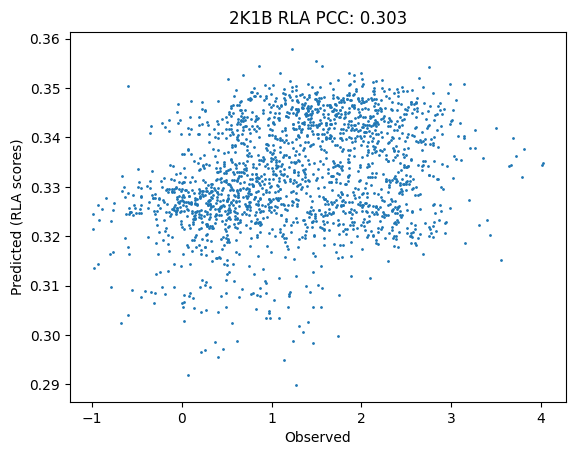

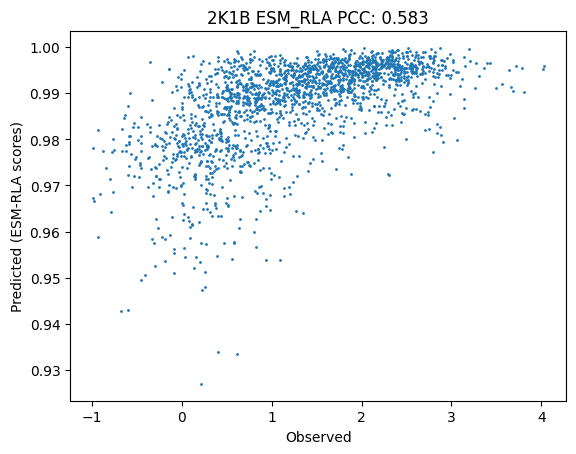

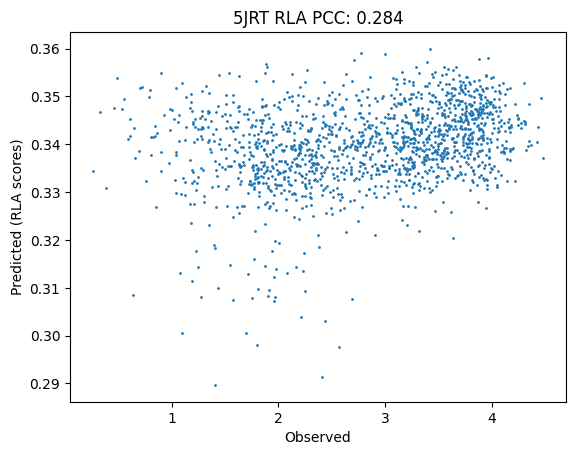

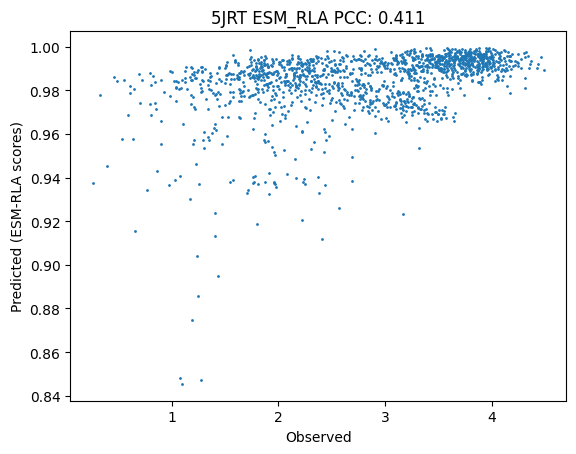

In [68]:
## Calculate statistics from results
for pdb in all_scores_muts.keys():
    pdb_dataset = stability_scores_drop[stability_scores_drop['WT_name'] == pdb + '.pdb']
    rla_df = pd.DataFrame(all_scores_muts[pdb])
    esm_rla_df = pd.DataFrame(all_scores_esm_rla_muts[pdb])
    results_merge = rla_df.merge(esm_rla_df).merge(pdb_dataset)
    rla_corr = results_merge['dG_ML'].corr(results_merge['RLA scores'])
    esm_rla_corr = results_merge['dG_ML'].corr(results_merge['ESM-RLA scores'])
    fig = plt.figure()
    plt.scatter(results_merge['dG_ML'], results_merge['RLA scores'], s=1)
    plt.xlabel('Observed')
    plt.ylabel('Predicted (RLA scores)')
    plt.title(f'{pdb} RLA PCC: {round(rla_corr, 3)}')
    
    fig = plt.figure()
    plt.scatter(results_merge['dG_ML'], results_merge['ESM-RLA scores'], s=1)
    plt.xlabel('Observed')
    plt.ylabel('Predicted (ESM-RLA scores)')
    plt.title(f'{pdb} ESM_RLA PCC: {round(esm_rla_corr, 3)}')
